## Ultimate Inc. Take Home Challenge
This notebook walks through the solutions for take home challenge by Ultimate Inc.

### Part 1 - Exploratory Data Analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import os
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import json
import matplotlib.pylab as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 8)

In [2]:
def logins_df():
    """
    Reads the logins.json file
    
    Returns a dataframe
    """
    logins_path = os.path.join('data', 'logins.json')
    # read file in string format
    str_data = json.load(open(logins_path))
    # using json normalize record the key 'login_time'
    logins = json_normalize(str_data, record_path='login_time')
    # set the column name to date
    logins.columns = ['date']
    # add a column 'val' with each row value set to 1
    # we can group by date and aggregate on 'val' column
    logins['val'] = 1
    # convert date column to pandas datetime 
    logins['date'] = pd.to_datetime(logins['date'])
    # set date column as index
    logins.set_index('date', inplace=True)
    return logins


def resample(df, interval):
    """
    Takes a dataframe and time interval to resample into
    
    Returns resampled dataframe
    """
    # resample the dataframe 
    temp_resample = df.resample(interval).count()
    return temp_resample


def custom_plot(df, axis, title, y_label=''):
    """
    Arguments:
    df: A dataframe
    axis: location of subplot
    title: title of subplot
    y_label: y label of subplot
    """
    plt.subplot(axis)
    plt.plot(df['val'])
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()

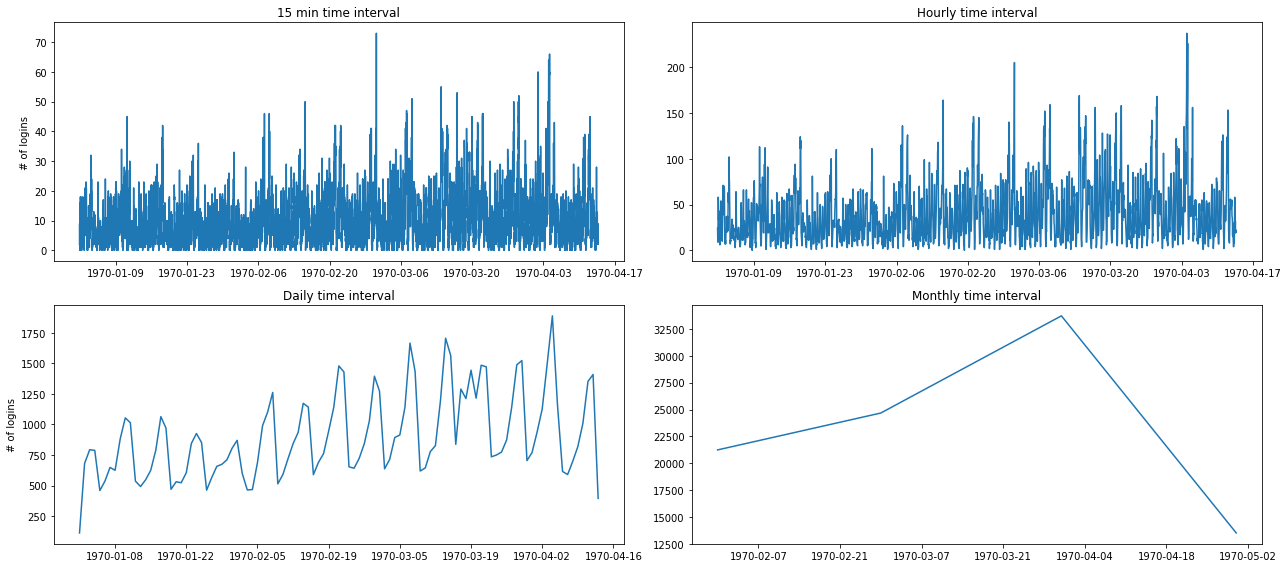

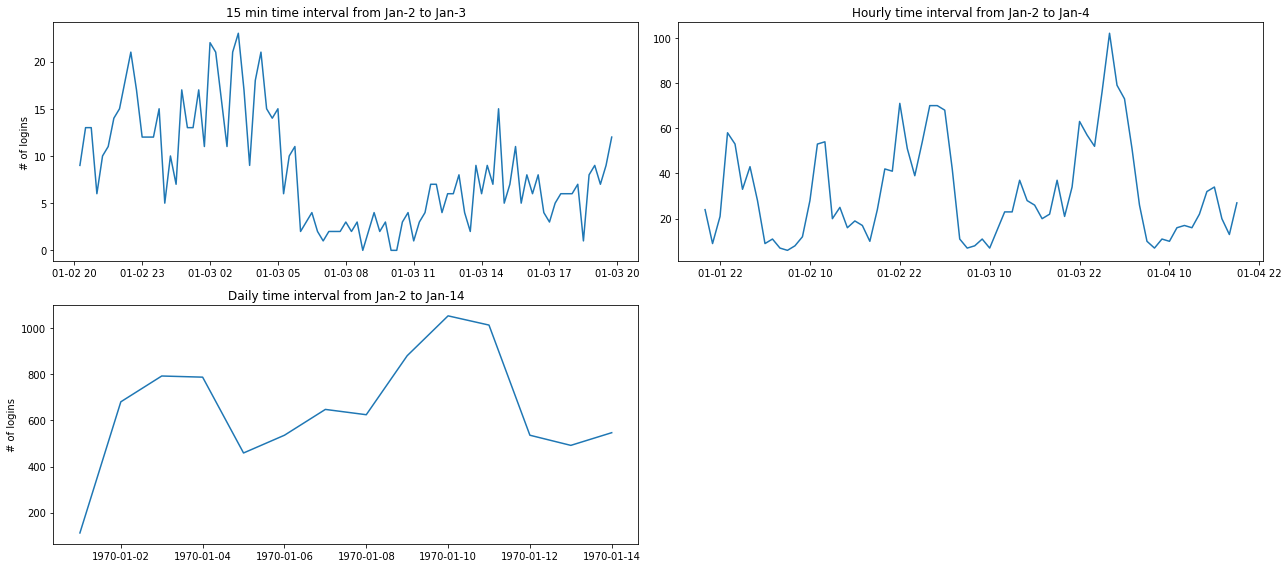

In [3]:
# read logins.json file
logins = logins_df()
#resampling
min15 = resample(logins, '15Min')
hourly = resample(logins, '60Min')
daily = resample(logins, 'D')
monthly = resample(logins, 'M')

# 15 Min
custom_plot(min15, 221, "15 min time interval", "# of logins")
# Hourly
custom_plot(hourly, 222, "Hourly time interval")
# Daily
custom_plot(daily, 223, "Daily time interval", "# of logins")
# Monthly
custom_plot(monthly, 224, "Monthly time interval")
plt.show()

# 15 Min
custom_plot(min15[97:192], 221, "15 min time interval from Jan-2 to Jan-3", "# of logins")
# Hourly
custom_plot(hourly[:72], 222, "Hourly time interval from Jan-2 to Jan-4")
# Daily
custom_plot(daily[:14], 223, "Daily time interval from Jan-2 to Jan-14", "# of logins")
plt.show()

In [4]:
# auto-correlation between 15min interval and its lag
print('======Correlation between 15min, 15min lag(previous 15min)=====')
print(pd.DataFrame({'actual': min15['val'], 'lag': min15['val'].shift()}).corr())

======Correlation between 15min, 15min lag(previous 15min)=====
        actual     lag
actual  1.0000  0.8307
lag     0.8307  1.0000


We can see that there is a trend being followed in the number of logins.<br>
Logins are more during the night compared to day time.<br>
There is an increasing trend from January to April<br>

From the auto correlation we can say that the current and previous 15 min values almost correlate. That implies previous value gives a best prediction for the next value.

### Part 2 - Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:<br>
    a. how you will implement the experiment<br>
    b. what statistical test(s) you will conduct to verify the significance of the observation<br>
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.<br>

#### Solution
From the given question, it is not stated that there is no toll during the weekends. So, assuming that there is toll 24/7 it could be possible that people are travelling to Metropolis during day to work and returning to Gotham at night. Population in Gotham is more but work is based in Metropolis. Also it is possible that Metropolis is a tourist place but people are not staying there because of costs!!<br>
In contrast to this, during the weekend both the cities are seeing a similar activity as mentioned in the question. The activity could be 1% or 2% compared to weekdays which is not good to compare. So, insufficient information is provided.<br>
However let\`s consider reimbursing toll costs, then:
1. I would choose activity as the key measure of success of this experiment because it provides a clear result from the activity. i.e. if people are following the same trends after reimbursing toll, then it is not worth it.
2. If the sample size is more than 30, I would choose one sample z-test
    * Sample should form a single treatment group. In this case people who received reimbursed toll
    * Null hypothesis is that there is a difference in driver patterns after reimbursing
    * Compute z-statistic
    * find a confidence interval , use the standard normal table to find if the z-stat falls in the confidence interval. Accept or reject the hypothesis

### Part 3 - Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. 
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. 
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

### Cleaning and EDA

In [5]:
def data_df():
    """
    Read json file and returns a dataframe
    """
    path = os.path.join('data', 'ultimate_data_challenge.json')
    # load the json files as dictionaries
    dicts = json.load(open(path))
    # convert dictionaries to dataframe
    df = pd.DataFrame(dicts)
    # convert signup_date  and last_trip_date to datetime
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    return df


def retentions_df(df):
    """
    Takes a dataframe
    Returns dataframe with retention column added
    """
    # get the most recent trip date
    from_day = max(df['last_trip_date'])
    # 30 days preciding the last trip date
    days = [from_day - datetime.timedelta(days=x) for x in range(0, 30)]
    # map functin to check if user is active in last 30 days
    df['retention'] = df['last_trip_date'].map(lambda x: int(x in days))
    return df


def transform_data(df):
    """
    Takes a dataframe and process so that it can 
    be used it further analysis
    """
    df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
    df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
    df['phone'].fillna('iPhone', inplace=True)
    
    # map city names to int
    cities = {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
    df['city'] = df['city'].map(lambda x: cities[x])
    # map device names to int
    phones = {'iPhone': 1, 'Android': 2}
    df['phone'] = df['phone'].map(lambda i: phones[i])
    # map boolean values to int
    df['ultimate_black_user'] = df['ultimate_black_user'].astype('int')
    # add a column 'active' which can have two values:
    # 1-if user is active in their 6th month
    # 0-if not
    df['active'] = ((df['last_trip_date'] - df['signup_date']) / np.timedelta64(1, 'M')).\
        map(lambda x: 1 if x > 5 else 0)
    # drop un-nescessary columns
    # surge_pct, avg_surge are very similar, so we dont need two similar features
    # last_trip_date and signup_date are both used to calculate retention which is our label
    df.drop(['last_trip_date', 'signup_date', 'surge_pct'], axis=1, inplace=True)
    return df

### Fraction of users retained

In [6]:
data = data_df()
retentions = retentions_df(data)
frac_ret = len(retentions[retentions['retention'] == 1])/len(retentions)
print("Fraction of users retained: " + str(frac_ret))

Fraction of users retained: 0.3662


### EDA

In [7]:
data = data_df()
clean_data = transform_data(data)
clean_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,3,1,4,1,46.2,0
1,8.26,5.0,5.0,1.00,2,2,0,0,50.0,0
2,0.77,5.0,4.3,1.00,2,1,3,0,100.0,0
3,2.36,4.9,4.6,1.14,3,1,9,1,80.0,1
4,3.13,4.9,4.4,1.19,1,2,14,0,82.4,0


In [8]:
print("=====0-Non Retained users, 1-Retained users=====")
print(clean_data['active'].value_counts())

=====0-Non Retained users, 1-Retained users=====
0    38806
1    11194
Name: active, dtype: int64


__10,342__ people were active in their 6th month

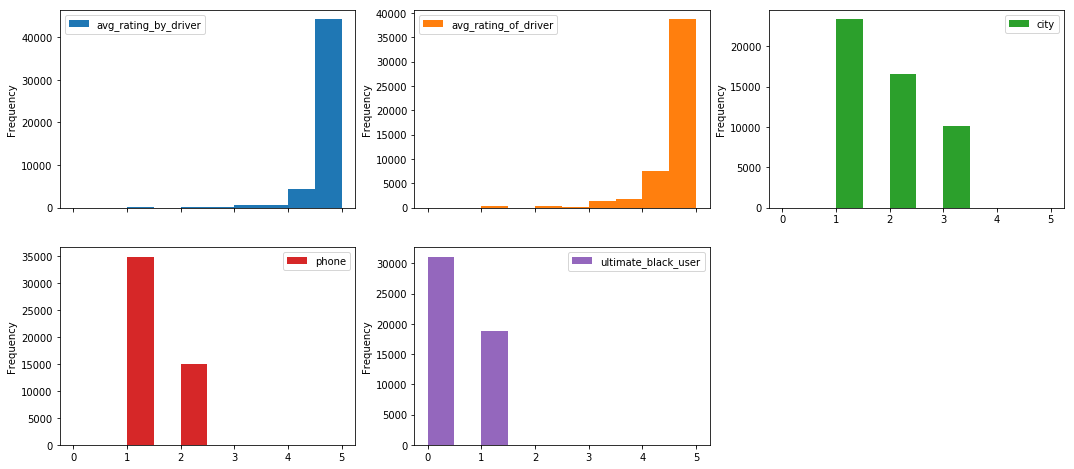

In [9]:
clean_data[['avg_rating_by_driver', 'avg_rating_of_driver', 'city', 'phone', 'ultimate_black_user']].\
plot(kind='hist', subplots=True, layout=(2,3), legend=True)
None

# cities = {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
# phones = {'iPhone': 1, 'Android': 2}

### Model to predict retention

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

#### Manual feature engineering

In [11]:
# get file and transform
data = data_df()
clean_data = transform_data(data)

# list of features to be dropped later
list1 = ['avg_dist', 'avg_surge', 'trips_in_first_30_days', 'ultimate_black_user',
         'avg_rating_by_driver', 'avg_rating_of_driver', 'weekday_pct']

# new feature 'avg1' by taking mean of ['avg_dist', 'avg_surge', 'trips_in_first_30_days']
clean_data['avg1'] = clean_data[['avg_dist', 'avg_surge', 'trips_in_first_30_days']].mean(axis=1)

# new feature 'avg2' by taking mean of ['avg_rating_by_driver', 'avg_rating_by_driver']
clean_data['avg2'] = clean_data[['avg_rating_by_driver', 'avg_rating_by_driver']].mean(axis=1)

# new feature 'fea1' by multiplying 'city', 'phone'
clean_data['fea1'] = clean_data['city'] * clean_data['phone'] * clean_data['ultimate_black_user']

# drop the un-needed features
clean_data.drop(list1, inplace=True, axis=1)
clean_data.drop(['city', 'phone'], inplace=True, axis=1)


# Train and test sets
x = clean_data.drop(['active'], axis=1)
y = clean_data['active']

# feature scaling
scaler = MinMaxScaler()
scaler.fit(x)
scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.03, stratify=y)

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

# score
print('Feature importance of the 3 features')
features = ['avg1', 'avg2', 'fea1']

print('=====Feature importance=======')
for idx, val in enumerate(clf.feature_importances_):
    print("{:20}{:3f}".format(features[idx], val))
print('-----------------------------------------------')

print("{:20}{:3f}".format('F1 score', f1_score(y_test, y_pred)))
print("{:20}{:3f}".format('Test accuracy', accuracy_score(y_test, y_pred)))
print()

print('====Confusion Matrix=====')
print(confusion_matrix(y_test, y_pred))

Feature importance of the 3 features
=====Feature importance=======
avg1                0.702705
avg2                0.234822
fea1                0.062473
-----------------------------------------------
F1 score            0.347368
Test accuracy       0.752000

====Confusion Matrix=====
[[1029  135]
 [ 237   99]]


#### Feature engineering using Principal component Analysis

In [12]:
# get file and transform
data = data_df()
clean_data = transform_data(data)

# use PCA to reduce features to 4
pca = decomposition.PCA(n_components=4, svd_solver='full')
pca.fit(clean_data.drop(['active'], axis=1))

x = pca.transform(clean_data.drop(['active'], axis=1))
y = clean_data['active']

# feature scaling
scaler = MinMaxScaler()
scaler.fit(x)
scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.03, stratify=y)

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

# score
print('Feature importance of the 4 features')
print(clf.feature_importances_)
print('-----------------------------------------------')

print("{:20}{:3f}".format('F1 score', f1_score(y_test, y_pred)))
print("{:20}{:3f}".format('Test accuracy', accuracy_score(y_test, y_pred)))
print()

print('====Confusion Matrix=====')
print(confusion_matrix(y_test, y_pred))
print()
print("====PCA weight matrix====")
print(pca.components_)

Feature importance of the 4 features
[ 0.33012754  0.18902044  0.2092992   0.27155282]
-----------------------------------------------
F1 score            0.358297
Test accuracy       0.708667

====Confusion Matrix=====
[[941 223]
 [214 122]]

====PCA weight matrix====
[[ -1.60071919e-02  -2.46884706e-04  -1.92738472e-04   6.60929331e-04
   -5.45220136e-04   1.13981469e-04  -5.17126549e-03  -4.72210861e-04
   -9.99857970e-01]
 [  9.86258946e-01   6.33173897e-03   2.79810273e-03  -2.69758296e-03
   -1.67313277e-03   2.25117753e-03  -1.64332157e-01   1.37034165e-03
   -1.49429170e-02]
 [  1.64215003e-01  -2.53532166e-03  -7.83161101e-04  -8.43012456e-04
   -3.54451843e-03  -6.72916513e-03   9.86236602e-01   1.56639148e-02
   -7.73582252e-03]
 [ -1.02884917e-03  -9.75195497e-02  -1.58646039e-01  -3.40221359e-03
   -9.80146136e-01   3.94407608e-02  -2.57818878e-03  -5.53141108e-02
    6.47308929e-04]]


Both feature engineering methods are giving almost similar results.<br>
Model is 70% accurate, but if the model sees more data related to retentions it would be even more accurate and F1 score improves.

Given data to a model, Ultimate would be able to predict user retention 70% accurately.<br>
1. Average distance, average surge and trips in first 30 days determine user retention
1. After feature engineering, it is evid that more importance is given to ratings. So improving the customer service can lead to good results
2. Improving interface on devices and accessibility in the cities could also lead to user retention